Testing FIBSEM Microscope overall class
    - Testing Thermo Fisher instance of class
    

Importing Relevant Modules

In [1]:
%load_ext autoreload
%autoreload 2

import fibsem
from fibsem import utils, acquire
import fibsem.alignment as fa
from fibsem.structures import BeamType, ImageSettings, GammaSettings, FibsemRectangle, FibsemImage, check_data_format
import matplotlib.pyplot as plt
from fibsem import FibsemMicroscope, calibration
import os
import logging
from fibsem.utils import current_timestamp, configure_logging
from pathlib import Path
from autoscript_sdb_microscope_client.structures import (
    AdornedImage,
    GrabFrameSettings,
    Rectangle,
    RunAutoCbSettings,
)

Importing settings from config

In [2]:
settings = utils.load_settings_from_config()


Testing Setup 

In [3]:
microscope, settings = utils.setup_session()

2022-12-07 13:52:34,722 — root — INFO — setup_session:284 — Finished setup for session: demo_2022-12-07-01-52-34PM


In [ ]:
print(microscope.connection.SEM.Beam.GetStatus())

In [ ]:
microscope.disconnect()

Setting up for image acquisition

In [ ]:
print(settings)

In [25]:
# set gamma settings
gamma_settings = GammaSettings(
        enabled=True,
        min_gamma=0.5,
        max_gamma=1.8,
        scale_factor=0.01,
        threshold=46,
    )

# set imaging settings
image_settings = ImageSettings(
        resolution="1536x1024",
        dwell_time=1.0e-6,
        hfw=150.0e-6,
        autocontrast=True,
        beam_type=BeamType.ION,
        gamma=gamma_settings,
        save=True,
        save_path="fibsem\\test_images",
        label=utils.current_timestamp(),
        reduced_area=None,
    )


Autoconcrast

In [ ]:
microscope.autocontrast(beam_type=image_settings.beam_type)
microscope.autocontrast(beam_type=BeamType.ION)


Take new image

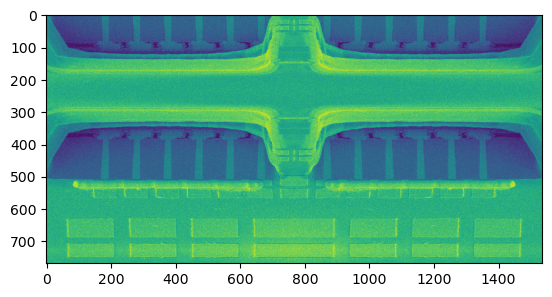

In [50]:
new_image = acquire.new_image(microscope, image_settings)

plt.imshow(new_image.data)
plt.show()


Checks

In [23]:
assert isinstance(new_image, FibsemImage)
assert check_data_format(new_image.data)

assert new_image.metadata.compare_image_settings(image_settings)
assert new_image.metadata.version == 'v1'
assert os.path.exists(f"{os.path.join(image_settings.save_path, image_settings.label)}_eb.tif")
#assert new_image.metadata.microscope_state.absolute_position == microscope.get_stage_position()

print(new_image.metadata.microscope_state)

MicroscopeState(timestamp=1670382724.884791, absolute_position=FibsemStagePosition(x=0.0, y=0.0, z=0.081, r=90.001, t=0.0, coordinate_system='Raw'), eb_settings=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=0.010021882, beam_current=3e-10, hfw=None, resolution='1536x1024', dwell_time=1e-06, stigmation=Point(x=0.0, y=0.0), shift=Point(x=0.0, y=0.0)), ib_settings=BeamSettings(beam_type=<BeamType.ION: 2>, working_distance=None, beam_current=None, hfw=None, resolution=None, dwell_time=None, stigmation=None, shift=None))


Take last image

In [ ]:
label = f"{image_settings.label}_last"

last_image = microscope.last_image(image_settings.beam_type)

plt.imshow(last_image.data)
plt.show()

if image_settings.save:
    filename = os.path.join(image_settings.save_path, label)
    last_image.save(save_path=filename)


Checks

In [ ]:
# assert isinstance(last_image, FibsemImage)
assert check_data_format(last_image.data)


# assert last_image.metadata.compare_image_settings(image_settings) # TODO: FIX THIS, different than img settings
assert last_image.metadata.version == 'v1'
assert os.path.exists(f"{filename}.tif")

print(last_image.metadata.microscope_state)

In [52]:
params = microscope.connection.FIB.Optics.EnumParameters()
print(new_image.metadata.microscope_state.ib_settings.working_distance)
print(microscope.connection.FIB.Optics.Get(1))
print(params)
print(params.find('Working Distance'))


0.012
[12.0, 0.0]
param.0.name=View Field
param.0.count=1
param.0.unit=mm
param.1.name=Working Distance
param.1.count=1
param.1.unit=mm

69


In [63]:
# find index
split_params = params.split("\n")
for i, word in enumerate(split_params):
    if "Working Distance" in word:
        idx = int(word.split(".")[1])
        count = int(split_params[i+1].split("=")[-1]) - 1
        unit = split_params[i+2].split("=")[-1]
# get index
print(count)
wd = microscope.connection.FIB.Optics.Get(idx)[count]

print(f"wd: {wd}{unit}")



1
wd: 0.0mm


Take reference images

In [ ]:
#taking set of ref images
hfws =  [400e-6, 150.0e-6]
ref_images = acquire.take_set_of_reference_images(microscope, image_settings,hfws)
fig = plt.figure(figsize=(10, 7))

print(ref_images)

fig.add_subplot(2, 2, 1)
plt.imshow(ref_images.low_res_eb.data)
fig.add_subplot(2, 2, 2)
plt.imshow(ref_images.high_res_eb.data)
fig.add_subplot(2, 2, 3)
plt.imshow(ref_images.low_res_ib.data)
fig.add_subplot(2, 2, 4)
plt.imshow(ref_images.high_res_ib.data)

#checking image data 
# if ref_images.low_res_eb.metadata.compare_image_settings(image_settings):
#     print("Image settings are the same")
# print(ref_images[0].metadata.microscope_state.timestamp)
# print(ref_images[0].metadata.version)


assert ref_images.low_res_eb.metadata.image_settings.hfw == hfws[0], f"hfw: {ref_images.low_res_eb.metadata.image_settings.hfw} != {hfws[0]}"
assert ref_images.low_res_ib.metadata.image_settings.hfw == hfws[0], f"hfw: {ref_images.low_res_ib.metadata.image_settings.hfw} != {hfws[0]}"
assert ref_images.high_res_eb.metadata.image_settings.hfw == hfws[1], f"hfw: {ref_images.high_res_eb.metadata.image_settings.hfw} != {hfws[1]}"
assert ref_images.high_res_ib.metadata.image_settings.hfw == hfws[1], f"hfw: {ref_images.high_res_ib.metadata.image_settings.hfw} != {hfws[1]}"


Beam shift

In [ ]:
print("electron: ", microscope.connection.beams.electron_beam.beam_shift.value)
print("ion: ", microscope.connection.beams.ion_beam.beam_shift.value)

microscope.reset_beam_shifts()

print("electron: ", microscope.connection.beams.electron_beam.beam_shift.value)
print("ion: ", microscope.connection.beams.ion_beam.beam_shift.value)

assert microscope.connection.beams.electron_beam.beam_shift.value.x == 0
assert microscope.connection.beams.electron_beam.beam_shift.value.y ==  0

assert microscope.connection.beams.ion_beam.beam_shift.value.x == 0
assert microscope.connection.beams.ion_beam.beam_shift.value.y ==  0

Disconnect from Microscope

In [ ]:
microscope.disconnect()